In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [2]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import sys
sys.path.append('/home/mei/nas/docker/thesis')
from dataloader.ts_reader import MultiModalDataset, collate_fn

from lstm_gnn_embedding_nograph import PatientOutcomeModelEmbedding
import pickle
from sklearn.manifold import TSNE
import numpy as np
from sklearn.cluster import KMeans

In [3]:
import gc
gc.collect()

torch.cuda.empty_cache()
torch.cuda.synchronize()

from torch.amp import GradScaler, autocast
scaler = GradScaler() 

In [4]:
flat_input_dim = 104
ts_input_dim = 162
hidden_dim = 128

In [5]:
train_data_dir = "/home/mei/nas/docker/thesis/data/hdf/train"
val_data_dir = "/home/mei/nas/docker/thesis/data/hdf/val"
test_data_dir = "/home/mei/nas/docker/thesis/data/hdf/test"

In [6]:
# === LSTM + Flat Dataset ===
lstm_dataset_train = MultiModalDataset(train_data_dir)
lstm_dataset_val = MultiModalDataset(val_data_dir)
lstm_dataset_test = MultiModalDataset(test_data_dir)

lstm_loader_train = DataLoader(lstm_dataset_train , batch_size=32, shuffle=True, collate_fn=collate_fn)
lstm_loader_val = DataLoader(lstm_dataset_val , batch_size=32, shuffle=False, collate_fn=collate_fn)
lstm_loader_test = DataLoader(lstm_dataset_test , batch_size=32, shuffle=False, collate_fn=collate_fn)



In [7]:
def evaluate_model(model, lstm_loader, criterion, device):
    model.eval()
    val_loss = 0.0
     
    with torch.no_grad():
        for patient_ids, ts_data, flat_data, risk_data,lengths in lstm_loader:
            ts_data, flat_data, risk_data,lengths = ts_data.to(device), flat_data.to(device), risk_data.to(device),lengths.to(device)

            outputs,_= model(flat_data, ts_data, lengths)
            
            ts_mask = ts_data != -99
            ts_mask = ts_mask.any(dim=2)
            risk_mask = risk_data != -99
            combined_mask = ts_mask & risk_mask

            masked_outputs = outputs[combined_mask]
            masked_risk_data = risk_data[combined_mask]

            loss = criterion(masked_outputs, masked_risk_data)
            val_loss += loss.item()

    return val_loss / len(lstm_loader)  

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   
model = PatientOutcomeModelEmbedding(flat_input_dim, ts_input_dim, hidden_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss() 

In [ ]:
best_model = '/home/mei/nas/docker/thesis/data/model_results_noGraph'
os.makedirs(best_model, exist_ok=True)

In [14]:
num_epochs=10

train_losses = []
val_losses = []
val_mse_losses = []

best_val_loss = float('inf')
best_model = '/home/mei/nas/docker/thesis/data/model_results_noGraph'
os.makedirs(best_model, exist_ok=True)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for patient_ids, ts_data, flat_data, risk_data,lengths in lstm_loader_train:
        ts_data, flat_data, risk_data,lengths = ts_data.to(device), flat_data.to(device), risk_data.to(device),lengths.to(device)

        # forward pass
        optimizer.zero_grad()
        with autocast(device_type='cuda', dtype=torch.float16):
            outputs,_ = model(flat_data,  ts_data,lengths)
            
            ts_mask = ts_data != -99
            ts_mask = ts_mask.any(dim=2)   # mask out the -99 values
            risk_mask = risk_data != -99
            combined_mask = ts_mask & risk_mask

            masked_outputs = outputs[combined_mask]
            masked_risk_data = risk_data[combined_mask]

            loss = criterion(masked_outputs, masked_risk_data)
             
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        torch.cuda.empty_cache()     
        
    train_loss /= len(lstm_loader_train)
    train_losses.append(train_loss)

    # calculate validation loss
    val_loss = evaluate_model(model, lstm_loader_val, criterion, device)
    val_losses.append(val_loss)
             
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_path = os.path.join(best_model, 'best_model_noGraph.pth')
            torch.save(model.state_dict(), save_path)
            print(f"Epoch {epoch+1}: Validation loss decreased to {val_loss:.4f}. Model saved to {save_path}.")

Epoch 1/10, Train Loss: 0.0173, Val Loss: 0.0192
Epoch 1: Validation loss decreased to 0.0192. Model saved to /home/mei/nas/docker/thesis/data/model_results_noGraph/best_model_noGraph.pth.
Epoch 2/10, Train Loss: 0.0168, Val Loss: 0.0191
Epoch 2: Validation loss decreased to 0.0191. Model saved to /home/mei/nas/docker/thesis/data/model_results_noGraph/best_model_noGraph.pth.
Epoch 3/10, Train Loss: 0.0162, Val Loss: 0.0190
Epoch 3: Validation loss decreased to 0.0190. Model saved to /home/mei/nas/docker/thesis/data/model_results_noGraph/best_model_noGraph.pth.
Epoch 4/10, Train Loss: 0.0159, Val Loss: 0.0189
Epoch 4: Validation loss decreased to 0.0189. Model saved to /home/mei/nas/docker/thesis/data/model_results_noGraph/best_model_noGraph.pth.
Epoch 5/10, Train Loss: 0.0151, Val Loss: 0.0179
Epoch 5: Validation loss decreased to 0.0179. Model saved to /home/mei/nas/docker/thesis/data/model_results_noGraph/best_model_noGraph.pth.
Epoch 6/10, Train Loss: 0.0146, Val Loss: 0.0182
Epoch 

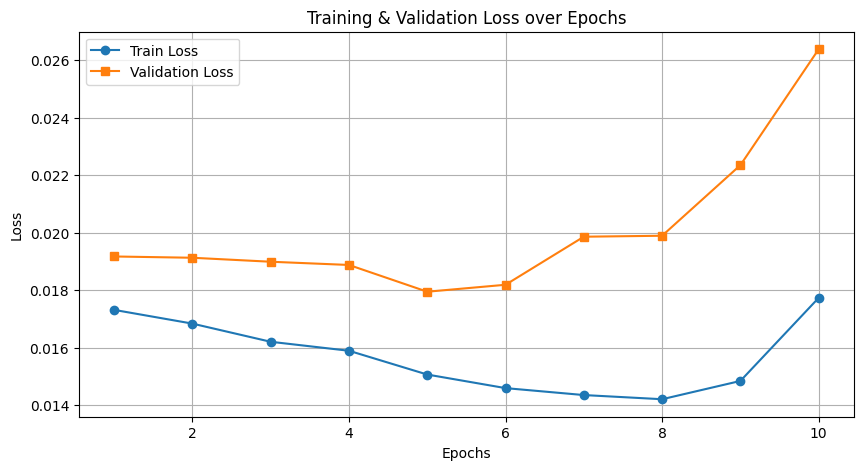

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss over Epochs")
plt.legend()
plt.grid()
plt.show()

## test model

In [16]:
best_model = '/home/mei/nas/docker/thesis/data/model_results_noGraph/best_model_noGraph.pth'
model.load_state_dict(torch.load(best_model,weights_only=True))

model.eval()
test_loss = 0.0

patient_embedding_dict = {} # used to store patient embeddings for each time step
patient_risk_dict = {} # used to store patient risk for each time step

with torch.no_grad():
    for batch_idx, (patient_ids, ts_data, flat_data, risk_data,lengths) in enumerate(lstm_loader_test):
        ts_data, flat_data, risk_data,lengths = ts_data.to(device), flat_data.to(device), risk_data.to(device),lengths.to(device)

        patient_ids_tensor = torch.tensor([int(pid) for pid in patient_ids], dtype=torch.long, device=device)

        outputs, embedding = model(flat_data, ts_data,lengths)
        
        ts_mask = ts_data != -99
        ts_mask = ts_mask.any(dim=2)
        risk_mask = risk_data != -99
        combined_mask = ts_mask & risk_mask

        masked_outputs = outputs[combined_mask]
        masked_risk_data = risk_data[combined_mask]
       
        loss = criterion(masked_outputs, masked_risk_data)
        test_loss += loss.item()
        
        outputs_np = outputs.detach().cpu().numpy()          # (batch_size, T)
        embeddings_np = embedding.detach().cpu().numpy()       # (batch_size, T, D)
        mask_np = combined_mask.detach().cpu().numpy()         # (batch_size, T)
        patient_ids_np = patient_ids_tensor.detach().cpu().numpy()  # (batch_size,)

        # take the valid time steps for each patient
        batch_size = outputs_np.shape[0]
        for i in range(batch_size):
            pid = patient_ids_np[i]
            valid_risk = outputs_np[i][mask_np[i]]       # (valid_T,)
            valid_embedding = embeddings_np[i][mask_np[i]]  # (valid_T, D)

            patient_embedding_dict[pid] = valid_embedding
            patient_risk_dict[pid] = valid_risk
    
test_loss /= len(lstm_loader_test)
print(f'Test Loss: {test_loss:.4f}')

save_dir = '/home/mei/nas/docker/thesis/data/model_results_noGraph' 
os.makedirs(save_dir, exist_ok=True)
torch.save(patient_embedding_dict, os.path.join(save_dir, 'test_patient_combined_embeddings.pth'))
torch.save(patient_risk_dict, os.path.join(save_dir, 'test_patient_risks.pth'))

Test Loss: 0.0161


In [ ]:
save_dir = '/home/mei/nas/docker/thesis/data/model_results_noGraph' 
patient_embeddings_dict = torch.load(os.path.join(save_dir, 'test_patient_combined_embeddings.pth'),weights_only= False)
patient_risk_dict = torch.load(os.path.join(save_dir, 'test_patient_risks.pth'),weights_only= False)

In [10]:
pid = 1004878
print(f"Patient {pid} embedding shape: {patient_embedding_dict[pid].shape}")
print(f"Patient {pid} risk shape: {patient_risk_dict[pid].shape}")

Patient 1004878 embedding shape: (1081, 128)
Patient 1004878 risk shape: (1081,)


In [18]:
import pandas as pd
hdf= '/home/mei/nas/docker/thesis/data/hdf/'
risk_socre = pd.read_hdf(hdf + 'final_risk_scores.h5', key='df').set_index('patient')

In [19]:
patient_id= 1004878
patient_risk = risk_socre.loc[patient_id]
print(patient_risk)

         time  discharge_risk_category  risk_score
patient                                           
1004878     1                        2    0.383450
1004878     2                        2    0.383392
1004878     3                        2    0.383334
1004878     4                        2    0.383275
1004878     5                        2    0.383217
...       ...                      ...         ...
1004878  1077                        2    0.300400
1004878  1078                        2    0.300300
1004878  1079                        2    0.300200
1004878  1080                        2    0.300100
1004878  1081                        2    0.300000

[1081 rows x 3 columns]


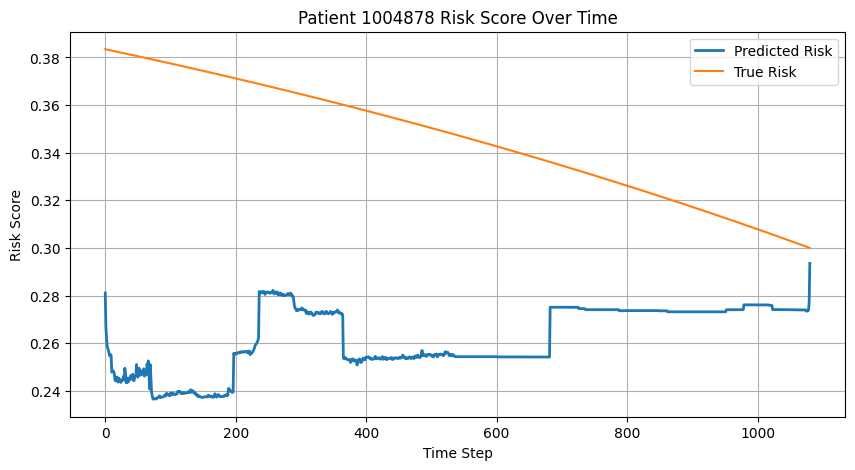

In [20]:
patient_id = 1004878
predicted_risk = patient_risk_dict[patient_id]  
patient_df = risk_socre.loc[patient_id]
patient_risk = patient_df['risk_score'].values

plt.figure(figsize=(10, 5))
plt.plot(predicted_risk , label='Predicted Risk',linestyle='-', linewidth=2)
plt.plot(patient_risk, label='True Risk')
plt.xlabel('Time Step')
plt.ylabel('Risk Score')
plt.title(f'Patient {patient_id} Risk Score Over Time')
plt.grid(True)
plt.legend()
plt.show()

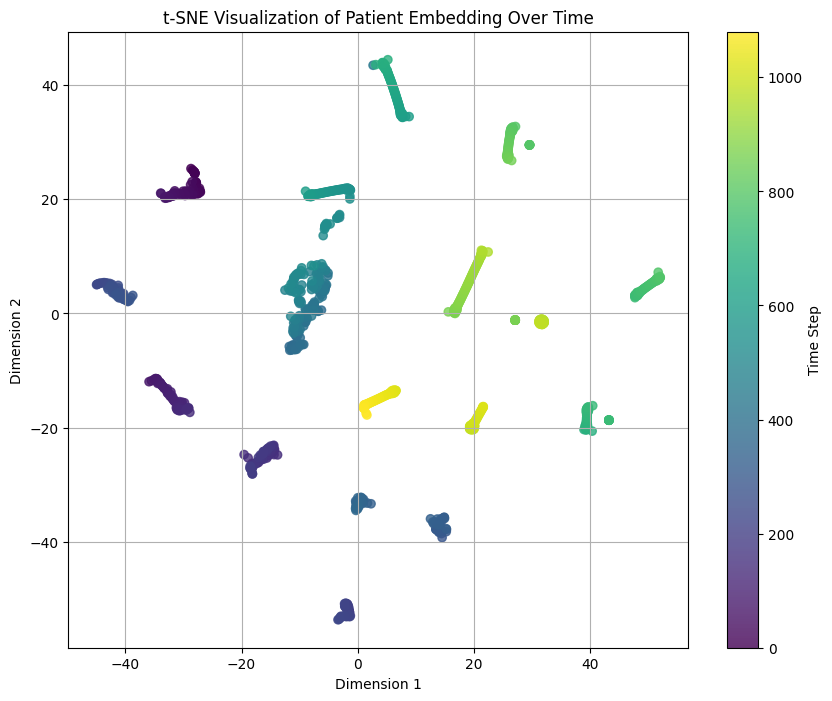

In [21]:
patient_embedding = patient_embedding_dict[patient_id] 
T, D = patient_embedding.shape
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embedding_2d = tsne.fit_transform(patient_embedding)  \

time_steps = np.arange(T)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=time_steps, cmap='viridis', alpha=0.8)
plt.colorbar(scatter, label='Time Step')
plt.title('t-SNE Visualization of Patient Embedding Over Time')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()
